<a href="https://colab.research.google.com/github/PavelStelmakhV/hw309-tensorflow/blob/main/tensorflow_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [9]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 2s 0us/step


In [10]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        # Место для вашего кода
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x):
        # Место для вашего кода
        y = tf.matmul(x, self.w) + self.b
        # return tf.nn.relu(y)
        return y

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Первый слой, состоящий из 128 нейронов
    # Место для вашего кода
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Второй слой, состоящий из 256 нейронов
    # Место для вашего кода
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Выходной слой
    # Место для вашего кода
    self.output_layer = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    # Место для вашего кода
    x = tf.math.sigmoid(self.layer_1(x))
    x = tf.math.sigmoid(self.layer_2(x))

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    x = tf.nn.softmax(self.output_layer(x))
    # x = tf.nn.softmax(x)

    return x

In [46]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    # Место для вашего кода

    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(y_true, y_pred)
    return m.result().numpy()

In [30]:
# temp1 = tf.Variable(2)
# temp2 = tf.Variable([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# acc = accuracy(temp2, temp1)
# print(acc)

In [ ]:
# tf.keras.metrics.CategoricalCrossentropy(
#     name='categorical_crossentropy',
#     dtype=None,
#     from_logits=False,
#     label_smoothing=0,
#     axis=-1
# )

In [32]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    # Место для вашего кода
    # trainable_variables = [nn.layer_1.w, nn.layer_1.b,
    #                        nn.layer_2.w, nn.layer_2.b,
    #                        nn.output_layer.w, nn.output_layer.b]
    trainable_variables = [nn.layer_1.w, nn.layer_1.b,
                           nn.layer_2.w, nn.layer_2.b]
    # Вычислим по ним значение градиента
    # Место для вашего кода
    gradients = g.gradient(loss, trainable_variables)
    # Модифицируем параметры
    # Место для вашего кода
    optimizer.apply_gradients(zip(gradients, trainable_variables))


In [47]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(1001), 0): # Место для вашего кода:
    # Обновляем веса нейронной сети
    # Место для вашего кода
    # print(batch_y)
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        # pred1 = tf.argmax(pred, axis=1, output_type=tf.int32)
        # Место для вашего кода

        loss_history.append(cross_entropy(pred, batch_y).numpy())
        accuracy_history.append(accuracy(pred, batch_y))
        # print(accuracy(batch_y, batch_y), accuracy(pred, pred))
        print(f'{step}, loss: {loss_history[-1]}, acc: {accuracy_history[-1]}')
#         print(pred.shape)

0, loss: 248.66177368164062, acc: 0.69140625
100, loss: 263.9630126953125, acc: 0.74609375
200, loss: 221.20359802246094, acc: 0.78515625
300, loss: 182.66574096679688, acc: 0.81640625
400, loss: 198.92820739746094, acc: 0.80078125
500, loss: 145.5430450439453, acc: 0.87109375
600, loss: 164.4290771484375, acc: 0.8359375
700, loss: 143.8682403564453, acc: 0.828125
800, loss: 121.14436340332031, acc: 0.84765625
900, loss: 89.40435028076172, acc: 0.89453125
1000, loss: 92.17569732666016, acc: 0.91015625


In [48]:
batch_y[1]

<tf.Tensor: shape=(), dtype=uint8, numpy=5>

In [49]:
pred[1]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.6529762e-04, 1.0854719e-04, 2.0714439e-05, 6.2160897e-03,
       2.5007801e-06, 9.8594981e-01, 2.5122732e-04, 3.9445717e-04,
       6.7799888e-03, 1.1132560e-04], dtype=float32)>

In [50]:
batch_y.shape

TensorShape([256])

In [51]:
pred.shape

TensorShape([256, 10])

In [52]:
print(loss_history)
print(accuracy_history)

[248.66177, 263.963, 221.2036, 182.66574, 198.9282, 145.54305, 164.42908, 143.86824, 121.14436, 89.40435, 92.1757]
[0.69140625, 0.74609375, 0.78515625, 0.81640625, 0.80078125, 0.87109375, 0.8359375, 0.828125, 0.84765625, 0.89453125, 0.91015625]


In [53]:
pred.shape

TensorShape([256, 10])

In [54]:
steps = list(range(0, 1001, 100))
steps

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

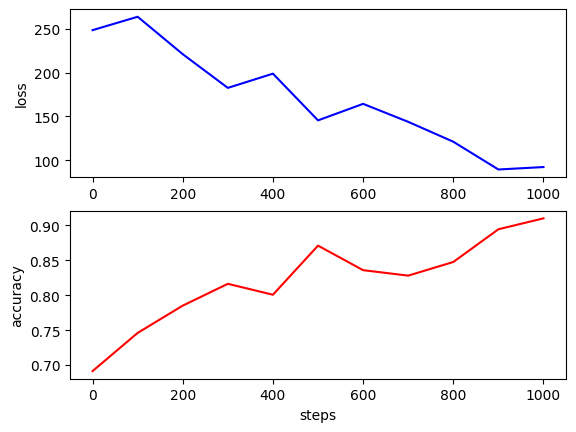

In [56]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

# Место для вашего кода
steps = list(range(0, 1001, 100))

plt.figure(1)
plt.subplot(2, 1, 1, ylabel='loss')
plt.plot(steps, loss_history, color='b')

plt.subplot(2, 1, 2, ylabel='accuracy', xlabel='steps')
plt.plot(steps, accuracy_history, color='r')


plt.show()

In [57]:
# Вычислите точность обученной нейросети

# Место для вашего кода

y_test_pred = neural_net(x_test)
acc = accuracy(y_test_pred, y_test)
print(f'accuracy: ', acc)

accuracy:  0.8653


In [58]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

# Место для вашего кода

